In [1]:
# DERIVE THE EOMs SYMBOLICALLY -------------------------------------------------------------------------------------

# import libraries
import sympy as sym
import numpy as np

sym.init_printing()
from IPython.display import display #for pretty printing


# ------------------------------------------------------------------------------------------------------------------
# create symbolic variables

# system parameters 
g = sym.symbols('g')
m1, l1, In1, d1 = sym.symbols(['m_{1}','l_{1}','I_{1}','d_{1}'])
m2, l2, In2, d2 = sym.symbols(['m_{2}','l_{2}','I_{2}','d_{2}'])
m3, l3, In3, d3 = sym.symbols(['m_{3}','l_{3}','I_{3}','d_{3}'])
#m4, l4, In4 = sym.symbols(['m_{4}','l_{4}','I_{4}'])



# generalized coordinates
x  ,  dx,  ddx = sym.symbols(['x'          ,'\dot{x}'          ,'\ddot{x}'])
y  ,  dy,  ddy = sym.symbols(['y'          ,'\dot{y}'          ,'\ddot{y}'])
th1,dth1,ddth1 = sym.symbols(['\\theta_{1}','\dot{\\theta}_{1}','\ddot{\\theta}_{1}'])
th2,dth2,ddth2 = sym.symbols(['\\theta_{2}','\dot{\\theta}_{2}','\ddot{\\theta}_{2}'])
th3,dth3,ddth3 = sym.symbols(['\\theta_{3}','\dot{\\theta}_{3}','\ddot{\\theta}_{3}'])
#th4,dth4,ddth4 = sym.symbols(['\\theta_{4}','\dot{\\theta}_{4}','\ddot{\\theta}_{4}'])

q   = sym.Matrix([  [x],  [y],  [th1],  [th2],  [th3]])
dq  = sym.Matrix([ [dx], [dy], [dth1], [dth2], [dth3]])
ddq = sym.Matrix([[ddx],[ddy],[ddth1],[ddth2],[ddth3]])

#q   = sym.Matrix([  [x],  [y],  [th1],  [th2],  [th3],  [th4]])
#dq  = sym.Matrix([ [dx], [dy], [dth1], [dth2], [dth3], [dth4]])
#ddq = sym.Matrix([[ddx],[ddy],[ddth1],[ddth2],[ddth3],[ddth4]])


# ------------------------------------------------------------------------------------------------------------------
# functions, # don't ask, they work for the purposes of this program
def WeirdRot(v, th):
    # weird rotation function for working with [x; y; th] vectors
    # usage: gives R_1^0 transformation, and adds the angle of rotation to result
    R = sym.Matrix([[sym.cos(th), -sym.sin(th), 0],
                    [sym.sin(th),  sym.cos(th), 0],
                   [       0,        0, 1]])
    S = sym.Matrix([[0],[0],[th]])
    return R*v + S

def WeirdAdd(v1, v2):
    # returns the sum of two vectors of the form [x; y; th]
    # both in the same ref. frame, preserving only the first angle
    v3 = sym.Matrix([[1],[1],[0]])
    return v1 + sym.matrix_multiply_elementwise(v3, v2)

def WeirdTrans(v1, ang1, off1, ang2=0, off2=sym.Matrix([[0],[0],[0]])):
    # ^ & ^ just like me
    # transforms [x,y,th] vector to inertial frame using position offsets and
    # rotation angles as specified
    rn_m = WeirdAdd(WeirdRot(v1, ang1),off1)
    rn_0 = WeirdAdd(WeirdRot(rn_m, ang2),off2)
    return rn_0


# ------------------------------------------------------------------------------------------------------------------
# mass positions, foot positions
r1_1 = sym.Matrix([[0],[0],[0]]) #sanity check
r1_0 = WeirdTrans(r1_1, th1, sym.Matrix([[x],[y],[0]]))

r2_2 = sym.Matrix([[0],[-l2*d2],[0]])
r2_0 = WeirdTrans(r2_2, th2, r1_1, th1, r1_0) #sanity check

r3_3 = sym.Matrix([[0],[-l3*d3],[0]])
r3_0 = WeirdTrans(r3_3, th3, r2_2, th1+th2, r2_0)

#r4_4 = sym.Matrix([[0],[l4*d4],[0]])
#r4_0 = WeirdTrans(r4_4, th4, r3_3, th1+th2+th3, r3_0)

# foot position
rfoot_3 = sym.Matrix([[0],[-l3],[0]])
rfoot_0 = WeirdTrans(rfoot_3, th3, r2_2, th1+th2, r2_0) #divide by d3 to get full link length



# mass velocities, foot velocity
dr1 = r1_0.jacobian(q)*dq
dr2 = r2_0.jacobian(q)*dq
dr3 = r3_0.jacobian(q)*dq
#dr4 = r4_0.jacobian(q)*dq

drfoot_0 = rfoot_0.jacobian(q)*dq


# ------------------------------------------------------------------------------------------------------------------
# kinetic and potential energy
def Ek(m, In, dr):
    InM = sym.Matrix([[m,0,0],[0,m,0],[0,0,In]])
    return 0.5*dr.T*InM*dr

def Ep(m, r):
    return sym.Matrix([m*g*r[1]])

T = Ek(m1,In1,dr1) + Ek(m2,In2,dr2) + Ek(m3,In3,dr3)
V = Ep(m1,r1_0) + Ep(m2,r2_0) + Ep(m3,r3_0)


# ------------------------------------------------------------------------------------------------------------------
# forces & torques
tau1, tau2, GRFx, GRFy = sym.symbols(['\\tau_{1}','\\tau_{2}','G_x','G_y'])

tau1_l1 = sym.Matrix([[0],[0],[-tau1]])
tau1_l2 = sym.Matrix([[0],[0], [tau1]])
tau2_l2 = sym.Matrix([[0],[0],[-tau2]])
tau2_l3 = sym.Matrix([[0],[0], [tau2]])

# tau3_l3 = sym.Matrix([[0],[0],[-tau3]])
# tau3_l4 = sym.Matrix([[0],[0], [tau3]])

#GRF_l3 = sym.Matrix([[GRFx],[GRFy],[0.5*l3*GRFx*sym.cos(th1+th2+th3)+0.5*l3*GRFy*sym.sin(th1+th2+th3)]])

GRF_r  = WeirdRot((1-d3)*rfoot_3, th1+th2+th3)
GRFth = GRF_r[0]*GRFy - GRF_r[1]*GRFx
GRF_l3 = sym.Matrix([[GRFx],[GRFy],[GRFth]])


Qtau1 = r1_0.jacobian(q).T*tau1_l1 + r2_0.jacobian(q).T*tau1_l2
Qtau2 = r2_0.jacobian(q).T*tau2_l2 + r3_0.jacobian(q).T*tau2_l3
QGRF  = rfoot_0.jacobian(q).T*GRF_l3

Qtot = Qtau1 + Qtau2 + QGRF

# ------------------------------------------------------------------------------------------------------------------
# Mass, Gravity, Coriolis matrices, EOM
LgM = sym.hessian(T, dq)
LgG = V.jacobian(q)

M_col = LgM.reshape(LgM.rows * LgM.cols, 1)
dM = M_col.jacobian(q)*dq
dM = dM.reshape(LgM.rows, LgM.cols)
Tj = T.jacobian(q)
LgC = dM*dq - Tj.T


EOM = LgM*ddq + LgC + LgG.T - Qtot
EOM0 = LgM*ddq - QGRF
display(sym.simplify(EOM))
display(sym.simplify(EOM0))

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢-2.0⋅Gₓ⋅d_{2}⋅l_{2}⋅cos(\theta_{1} + \theta_{2}) + 1.0⋅Gₓ⋅d_{3}⋅l_{3}⋅cos(\th
⎢                                                                             
⎢                                                                             
⎢       -2.0⋅Gₓ⋅d_{2}⋅l_{2}⋅cos(\theta_{1} + \theta_{2}) + 1.0⋅Gₓ⋅d_{3}⋅l_{3}⋅
⎢                                                                             
⎢                                                   

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢Gₓ⋅l_{3}⋅(d_{3} - 1)⋅cos(\theta_{1} + \theta_{2} + \theta_{3}) - Gₓ⋅(2⋅d_{2}⋅
⎢                                                                             
⎢                                                                             
⎢    Gₓ⋅l_{3}⋅(d_{3} - 1)⋅cos(\theta_{1} + \theta_{2} + \theta_{3}) - Gₓ⋅(2⋅d_
⎢                                                                             
⎢                                                                             
⎣                                                                             

                                                   

In [2]:
display(T)

⎡                          2                                                  
⎣0.5⋅I_{1}⋅\dot{\theta}_{1}  + I_{2}⋅(0.5⋅\dot{\theta}_{1} + 0.5⋅\dot{\theta}_

                                                                              
{2})⋅(\dot{\theta}_{1} + \dot{\theta}_{2}) + I_{3}⋅(0.5⋅\dot{\theta}_{1} + 0.5

                                                                              
⋅\dot{\theta}_{2} + 0.5⋅\dot{\theta}_{3})⋅(\dot{\theta}_{1} + \dot{\theta}_{2}

                                  2                    2                      
 + \dot{\theta}_{3}) + 0.5⋅\dot{x} ⋅m_{1} + 0.5⋅\dot{y} ⋅m_{1} + m_{2}⋅(0.5⋅\d

                                                                              
ot{\theta}_{1}⋅(-d_{2}⋅l_{2}⋅sin(\theta_{1})⋅sin(\theta_{2}) + d_{2}⋅l_{2}⋅cos

                                                                              
(\theta_{1})⋅cos(\theta_{2})) + 0.5⋅\dot{\theta}_{2}⋅(-d_{2}⋅l_{2}⋅sin(\theta_

                                              

In [3]:
# # LAMBDIFY ------------------------------------------------------------------------------------------------------------------    
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

func_map = {'sin':sin, 'cos':cos} 

# sym_list = [g,
#             m1,l1,In1,
#             m2,l2,In2,
#             m3,l3,In3,
#             d1,d2,d3,
#             x,dx,ddx,
#             y,dy,ddy,
#             th1,dth1,ddth1,
#             th2,dth2,ddth2,
#             th3,dth3,ddth3,
#             tau1,tau2,GRFx,GRFy]


sym_list = [g,
            m1 , m2, m3,
            l1 , l2, l3,
            In1,In2,In3,
            d1 , d2, d3,
            x  ,  y,  th1,  th2,  th3,
            dx , dy, dth1, dth2, dth3,
            ddx,ddy,ddth1,ddth2,ddth3,
            tau1,tau2,
            GRFx,GRFy]

lamb_EOM = {}
lamb_EOM0 = {}

# DOFs
DOFs =  ['x','y','th1','th2','th3']
TDOFs = ['x','y']

for dof_i, dof in enumerate(DOFs):
    lamb_EOM[dof]  = sym.lambdify(sym_list, EOM[dof_i],modules = [func_map])
    lamb_EOM0[dof] = sym.lambdify(sym_list,EOM0[dof_i],modules = [func_map])
    
lamb_footp = {}
lamb_footv = {}
for dof_i, dof in enumerate(TDOFs):
    lamb_footp[dof] = sym.lambdify(sym_list, rfoot_0[dof_i],modules = [func_map])
    lamb_footv[dof] = sym.lambdify(sym_list,drfoot_0[dof_i],modules = [func_map])


In [4]:
# PARAMETERS:
mass = {'b': 0.5,
       'l1': 0.25,
       'l2': 0.25}

length = {'b': 1,
         'l1': 0.5,
         'l2': 0.5}

dCOM = {'b': 0.5,
       'l1': 0.5,
       'l2': 0.5}

inertia = {'b': mass['b']*length['b']**2/12,
          'l1': mass['l1']*length['l1']**2/12,
          'l2': mass['l2']*length['l2']**2/12}

links = ['b','l1','l2']
joints = ['hip','knee']

def get_var_list(m,n):
    var_list = [m.g]+\
               [m.m[l] for l in links]+\
               [m.len[l] for l in links]+\
               [m.In[l] for l in links]+\
               [m.dCOM[l] for l in links]+\
               [m.q[n,dof] for dof in DOFs]+\
               [m.dq[n,dof] for dof in DOFs]+\
               [m.ddq[n,dof] for dof in DOFs]+\
               [m.tau[n,j] for j in joints]+\
               [m.GRF[n,dof] for dof in TDOFs]

    return var_list


In [34]:
def create_model(N,hm,mu):
    m = ConcreteModel()
    
    #SETS---------------------------------
    m.N =RangeSet(N)
    m.L =Set(initialize = links)
    m.J = Set(initialize = joints)
    m.DOF = Set(initialize= DOFs)
    m.TDOF = Set(initialize = TDOFs)
    
    #PARAMS-------------------------------
    m.g = Param(initialize = 9.81)
    m.mu = Param(initialize = mu)
    
    m.m = Param(m.L, initialize = mass)
    m.len = Param(m.L, initialize = length)
    m.In = Param(m.L, initialize = inertia)
    m.dCOM = Param(m.L, initialize = dCOM)
    
    signs = ['ps','ng']
    m.sgn = Set(initialize = signs)
    
    #VARIABLES----------------------------
    #gen coordinates
    m.q = Var(m.N,m.DOF)
    m.dq = Var(m.N,m.DOF)
    m.ddq = Var(m.N,m.DOF)
    
    #forces
    m.tau = Var(m.N,m.J)
    m.GRF = Var(m.N,m.TDOF)

# ------------------------------------------------------------------------------------------------------------------
    #TIME AND INTEGRATION

    # timestep
    m.hm = Param(initialize = hm, mutable = True) # master timestep
    m.h = Var(m.N, bounds = (0.8,1.0))
    
    # Integration constraints 
    def BwEuler_p(m,n,dof): # for positions
        if n > 1:
            return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
        else:
            return Constraint.Skip 
    m.integrate_p = Constraint(m.N, m.DOF, rule = BwEuler_p)

    def BwEuler_v(m,n,dof): # for velocities
        if n > 1:
            return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n-1,dof]
        else:
            return Constraint.Skip 
    m.integrate_v = Constraint(m.N, m.DOF, rule = BwEuler_v)
    
    def dynamics(m,n,dof):
        var_list = get_var_list(m,n)
        temp = lamb_EOM[dof](*var_list) == 0
#         if temp in [None, True, False]:
#             return Constraint.Skip
#         else:
        return temp
    m.dynamic = Constraint(m.N,m.DOF, rule = dynamics)


# ------------------------------------------------------------------------------------------------------------------
    # Link Bounds ------------------------
    for n in range(1,N+1):
        m.GRF[n,'y'].setlb(0)
#         m.tau[n,'hip'].setlb(-20)
#         m.tau[n,'hip'].setub(20)
#         m.tau[n,'knee'].setlb(-10)
#         m.tau[n,'knee'].setub(10)
        for link in links:
            m.q[n,'x'].setlb(0.0)
            m.q[n,'y'].setlb(0.0)
            m.q[n,'th1'].setlb(-np.pi/2)
            m.q[n,'th1'].setub(np.pi/2)
            m.q[n,'th2'].setlb(-np.pi/2)
            m.q[n,'th2'].setub(np.pi/2)
            m.q[n,'th3'].setlb(-np.pi/2)
            m.q[n,'th3'].setub(np.pi/2)


    #Ground Constraints ------------------
    m.footp = Var(m.N, m.TDOF, bounds = (0.0,None))
    def def_footp(m,n,dof):
        if dof == 'x':
            return Constraint.Skip
        else:
            var_list = get_var_list(m,n)
            return m.footp[n,dof] == lamb_footp[dof](*var_list)
    m.def_footp = Constraint(m.N, m.TDOF, rule = def_footp)
        
    m.footv = Var(m.N, m.TDOF)
    def def_footv(m,n,dof):
        if dof == 'y':
            return Constraint.Skip
        else:
            var_list = get_var_list(m,n)
            return m.footv[n,dof] == lamb_footv[dof](*var_list)
    m.def_footv = Constraint(m.N, m.TDOF, rule = def_footv)




   # COST FUNCTION -------------------------------------------------------------------------------------------------------------

    # minimum time

    def CostFun(m):
        T = sum(m.h[n] for n in range(1,N+1))
        penalty_sum = sum([m.ground_penalty[n,gc] for n in range(1,N+1) for gc in ground_constraints])
        #ain't single-line for loops grand?
        #return T+1000*penalty_sum
        return penalty_sum # for sanity checks
    m.Cost = Objective(rule = CostFun)
    
    return m


In [6]:
def init_opt(max_iter, max_time): # initializes solver
    opt = SolverFactory('ipopt') # standard issue, garden variety ipopt
    opt.options["linear_solver"] = 'ma97'
    opt.options["print_level"] = 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
    opt.options["max_iter"] = max_iter # maximum number of iterations
    opt.options["max_cpu_time"] = max_time # maximum cpu time in seconds
    opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.
    
    opt.options["OF_acceptable_obj_change_tol"] = 1e-4
    opt.options["OF_ma86_scaling"] = 'none'
    
    return opt


In [24]:
# HIGH DROP -----------------------------------------------------------------------------------------------------------------

def high_drop(m):
    # initial condition
    for dof in DOFs:
        m.ddq[1,dof].fix(0)
        m.dq[ 1,dof].fix(0) # rest
        if dof != 'y':
            m.q[1,dof].fix(0) # neutral posture
    m.footp[1,'y'].fix(10)

    for n in range(1,N+1):
        for j in joints:
            m.tau[n,j].fix(0.1)
        for dof in TDOFs:
            m.GRF[n,dof].fix(0) # no forces

    #m.q[N-1,'y'].fix(0)
    return m


In [30]:
N = 100
hm = 0.02
mu = 1.0
m = create_model(N,hm,mu)

m = high_drop(m)

opt = init_opt(3000,300)
results = opt.solve(m,tee=True)


Ipopt 3.13.4: linear_solver=ma97
print_level=5
max_iter=3000
max_cpu_time=300
Tol=1e-06
option_file_name=/tmp/tmp57zyw411_ipopt.opt

Using option file "/tmp/tmp57zyw411_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.4, running with linear solver ma97.

Number of nonzeros in equality constraint Jacobian...:    11071
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     5737

Total number of variables............................:     1784
                     variables with only lower bounds:      298
                variables with lower and upper

 105r 0.0000000e+00 9.81e+00 2.35e+02  -1.8 3.62e+00  -0.3 1.00e+00 1.73e-01f  1
 106r 0.0000000e+00 9.81e+00 2.03e+02  -1.8 1.76e+01  -0.8 2.67e-02 8.42e-02f  1
 107r 0.0000000e+00 9.81e+00 1.71e+02  -1.8 4.24e+00  -0.4 5.47e-01 1.65e-01f  1
 108r 0.0000000e+00 9.81e+00 2.29e+02  -1.8 1.28e+00   0.0 1.00e+00 5.62e-02f  1
 109r 0.0000000e+00 9.81e+00 2.03e+02  -1.8 4.38e+00  -0.4 4.67e-01 1.97e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110r 0.0000000e+00 9.81e+00 1.71e+02  -1.8 1.27e+02  -0.9 2.34e-04 1.15e-02f  1
 111r 0.0000000e+00 9.81e+00 2.13e+02  -1.8 6.20e+00  -0.5 4.10e-01 2.66e-02f  1
 112r 0.0000000e+00 9.81e+00 1.77e+02  -1.8 2.05e-01   0.8 4.52e-01 1.77e-02f  1
 113r 0.0000000e+00 9.81e+00 2.05e+01  -1.8 6.18e-01   0.4 1.00e+00 9.16e-01f  1
 114r 0.0000000e+00 9.81e+00 5.60e+01  -1.8 2.06e+00  -0.1 1.00e+00 2.51e-01f  1
 115r 0.0000000e+00 9.81e+00 7.07e+01  -1.8 7.37e+00  -0.6 4.93e-01 1.99e-01f  1
 116r 0.0000000e+00 9.81e+00

 243r 0.0000000e+00 9.81e+00 5.97e+02  -4.1 1.97e+02    -  3.24e-01 2.08e-01f  1
 244r 0.0000000e+00 9.81e+00 6.64e+02  -4.1 1.56e+02    -  3.84e-01 1.40e-03f  1
 245r 0.0000000e+00 9.81e+00 6.05e+02  -4.1 1.35e+02    -  8.52e-03 8.61e-02f  1
 246r 0.0000000e+00 9.81e+00 5.07e+02  -4.1 1.43e+02    -  1.93e-01 1.69e-01f  1
 247r 0.0000000e+00 9.81e+00 5.04e+02  -4.1 9.84e+01    -  2.20e-01 1.23e-04f  1
 248r 0.0000000e+00 9.81e+00 3.98e+02  -4.1 1.15e+02    -  2.40e-01 2.15e-01f  1
 249r 0.0000000e+00 9.81e+00 3.79e+02  -4.1 7.88e+01    -  1.38e-01 4.57e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250r 0.0000000e+00 9.81e+00 2.89e+02  -4.1 8.38e+01    -  2.77e-01 2.43e-01f  1
 251r 0.0000000e+00 9.81e+00 2.65e+02  -4.1 5.60e+01    -  2.36e-01 6.58e-02f  1
 252r 0.0000000e+00 9.81e+00 2.44e+02  -4.1 4.50e+01    -  1.69e-01 5.48e-02f  1
 253r 0.0000000e+00 9.81e+00 1.62e+02  -4.1 4.45e+01    -  8.19e-01 2.22e-01f  1
 254r 0.0000000e+00 9.81e+00

In [31]:
# if the problem is infeasible, this is how you can see which constraints weren't satisfied
from pyomo.util.infeasible import log_infeasible_constraints
log_infeasible_constraints(m)

INFO: CONSTR integrate_v[2,x]: 0.17377573538621865 =/= 0.0
INFO: CONSTR integrate_v[2,y]: 1.1282524528766558 =/= 0.0
INFO: CONSTR integrate_v[2,th1]: 0.8967416859769899 =/= 0.0
INFO: CONSTR integrate_v[2,th2]: -1.4029691611540005 =/= 0.0
INFO: CONSTR dynamic[1,y]: 9.81 =/= 0.0
INFO: CONSTR dynamic[1,th2]: -0.1 =/= 0.0
INFO: CONSTR dynamic[1,th3]: -0.1 =/= 0.0
INFO: CONSTR dynamic[2,th3]: -0.29123908335740906 =/= 0.0
INFO: CONSTR dynamic[10,th3]: -1.7137135169032636 =/= 0.0


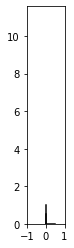

In [32]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

xmax = np.max([m.q[n,'x'].value for n in range(1,N+1)])
ymax = np.max([m.q[n,'y'].value for n in range(1,N+1)])

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-1,xmax+1]) # adjust limits to solution
    ax.set_ylim([0,ymax+0.5])
    
    #plot body
    body_xb = m.q[i,'x'].value - 0.5*m.len[('b')]*cos(m.q[i,'th1'].value)
    body_yb = m.q[i,'y'].value - 0.5*m.len[('b')]*sin(m.q[i,'th1'].value)
    body_xf = m.q[i,'x'].value + 0.5*m.len[('b')]*cos(m.q[i,'th1'].value)
    body_yf = m.q[i,'y'].value + 0.5*m.len[('b')]*sin(m.q[i,'th1'].value)  
    ax.plot([body_xb,body_xf],[body_yb,body_yf],color='xkcd:black')
      
    #plot leg 1
    thA = m.q[i,'th1'].value+m.q[i,'th2'].value
    leg1_xt = m.q[i,'x'].value
    leg1_yt = m.q[i,'y'].value
    leg1_xb = m.q[i,'x'].value + m.len[('l1')]*sin(thA)
    leg1_yb = m.q[i,'y'].value - m.len[('l1')]*cos(thA)
    ax.plot([leg1_xt,leg1_xb],[leg1_yt,leg1_yb],color='xkcd:black')
    
    #plot leg 2
    thB = m.q[i,'th1'].value+m.q[i,'th2'].value+m.q[i,'th3'].value
    leg2_xt = leg1_xb
    leg2_yt = leg1_yb
    leg2_xb = leg1_xb + m.len[('l2')]*sin(thB)
    leg2_yb = leg1_yb - m.len[('l2')]*cos(thB)
    ax.plot([leg2_xt,leg2_xb],[leg2_yt,leg2_yb],color='xkcd:black')
    
update = lambda i: plot_robot(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook


In [33]:
m.pprint()

17 Set Declarations
    DOF : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {'x', 'y', 'th1', 'th2', 'th3'}
    GRF_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain : Size : Members
        None :     2 : N*TDOF :  200 : {(1, 'x'), (1, 'y'), (2, 'x'), (2, 'y'), (3, 'x'), (3, 'y'), (4, 'x'), (4, 'y'), (5, 'x'), (5, 'y'), (6, 'x'), (6, 'y'), (7, 'x'), (7, 'y'), (8, 'x'), (8, 'y'), (9, 'x'), (9, 'y'), (10, 'x'), (10, 'y'), (11, 'x'), (11, 'y'), (12, 'x'), (12, 'y'), (13, 'x'), (13, 'y'), (14, 'x'), (14, 'y'), (15, 'x'), (15, 'y'), (16, 'x'), (16, 'y'), (17, 'x'), (17, 'y'), (18, 'x'), (18, 'y'), (19, 'x'), (19, 'y'), (20, 'x'), (20, 'y'), (21, 'x'), (21, 'y'), (22, 'x'), (22, 'y'), (23, 'x'), (23, 'y'), (24, 'x'), (24, 'y'), (25, 'x'), (25, 'y'), (26, 'x'), (26, 'y'), (27, 'x'), (27, 'y'), (28, 'x'), (28, 'y'), (29, 'x'), (29, 'y'), (30, 'x'), (30, 'y'), (31, 'x'), (31, 'y'), (32, 'x'), (32

        Key        : Lower : Value               : Upper : Fixed : Stale : Domain
          (1, 'x') :   0.0 :                None :  None : False :  True :  Reals
          (1, 'y') :   0.0 :                  10 :  None :  True :  True :  Reals
          (2, 'x') :   0.0 :                None :  None : False :  True :  Reals
          (2, 'y') :   0.0 :  10.022616305035823 :  None : False : False :  Reals
          (3, 'x') :   0.0 :                None :  None : False :  True :  Reals
          (3, 'y') :   0.0 :   10.03908624548216 :  None : False : False :  Reals
          (4, 'x') :   0.0 :                None :  None : False :  True :  Reals
          (4, 'y') :   0.0 :  10.052227867557491 :  None : False : False :  Reals
          (5, 'x') :   0.0 :                None :  None : False :  True :  Reals
          (5, 'y') :   0.0 :     10.062891682383 :  None : False : False :  Reals
          (6, 'x') :   0.0 :                None :  None : False :  True :  Reals
          (6, 'y

          (93, 'hip') :  None :   0.1 :  None :  True :  True :  Reals
         (93, 'knee') :  None :   0.1 :  None :  True :  True :  Reals
          (94, 'hip') :  None :   0.1 :  None :  True :  True :  Reals
         (94, 'knee') :  None :   0.1 :  None :  True :  True :  Reals
          (95, 'hip') :  None :   0.1 :  None :  True :  True :  Reals
         (95, 'knee') :  None :   0.1 :  None :  True :  True :  Reals
          (96, 'hip') :  None :   0.1 :  None :  True :  True :  Reals
         (96, 'knee') :  None :   0.1 :  None :  True :  True :  Reals
          (97, 'hip') :  None :   0.1 :  None :  True :  True :  Reals
         (97, 'knee') :  None :   0.1 :  None :  True :  True :  Reals
          (98, 'hip') :  None :   0.1 :  None :  True :  True :  Reals
         (98, 'knee') :  None :   0.1 :  None :  True :  True :  Reals
          (99, 'hip') :  None :   0.1 :  None :  True :  True :  Reals
         (99, 'knee') :  None :   0.1 :  None :  True :  True :  Reals
      

        Key        : Lower : Body                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    : Upper : Active
          (1, 'x') :   0.0 :                                                               footv[1,x] - (dq[1,x] + dq[1,th3]*(-0.5*sin(q[1,th3])*sin(q[1,th2] + q[1,th1]) + 0.5*cos(q[1,th3])*cos(q[1,th2] + q[1,th1])) + dq[1,th2]*(-0.5*sin(q[1,th3])*sin(q[1,th2] + q[1,th1]) - 0.25*sin(q[1,th2])*sin(q[1,th1]) + 0.25*cos(q[1,th2])*cos(q[1,th1]) + (0.5*cos(q[1,th3]) + 0.25)*cos(q[1,th2] + q[1,th1])) + dq

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



        Key          : Lower : Body                                               : Upper : Active
          (2, 'th1') :   0.0 :        q[2,th1] - (q[1,th1] + 0.02*h[2]*dq[2,th1]) :   0.0 :   True
          (2, 'th2') :   0.0 :        q[2,th2] - (q[1,th2] + 0.02*h[2]*dq[2,th2]) :   0.0 :   True
          (2, 'th3') :   0.0 :        q[2,th3] - (q[1,th3] + 0.02*h[2]*dq[2,th3]) :   0.0 :   True
            (2, 'x') :   0.0 :              q[2,x] - (q[1,x] + 0.02*h[2]*dq[2,x]) :   0.0 :   True
            (2, 'y') :   0.0 :              q[2,y] - (q[1,y] + 0.02*h[2]*dq[2,y]) :   0.0 :   True
          (3, 'th1') :   0.0 :        q[3,th1] - (q[2,th1] + 0.02*h[3]*dq[3,th1]) :   0.0 :   True
          (3, 'th2') :   0.0 :        q[3,th2] - (q[2,th2] + 0.02*h[3]*dq[3,th2]) :   0.0 :   True
          (3, 'th3') :   0.0 :        q[3,th3] - (q[2,th3] + 0.02*h[3]*dq[3,th3]) :   0.0 :   True
            (3, 'x') :   0.0 :              q[3,x] - (q[2,x] + 0.02*h[3]*dq[3,x]) :   0.0 :   True
          

        Key          : Lower : Body                                                 : Upper : Active
          (2, 'th1') :   0.0 :       dq[2,th1] - (dq[1,th1] + 0.02*h[2]*ddq[1,th1]) :   0.0 :   True
          (2, 'th2') :   0.0 :       dq[2,th2] - (dq[1,th2] + 0.02*h[2]*ddq[1,th2]) :   0.0 :   True
          (2, 'th3') :   0.0 :       dq[2,th3] - (dq[1,th3] + 0.02*h[2]*ddq[1,th3]) :   0.0 :   True
            (2, 'x') :   0.0 :             dq[2,x] - (dq[1,x] + 0.02*h[2]*ddq[1,x]) :   0.0 :   True
            (2, 'y') :   0.0 :             dq[2,y] - (dq[1,y] + 0.02*h[2]*ddq[1,y]) :   0.0 :   True
          (3, 'th1') :   0.0 :       dq[3,th1] - (dq[2,th1] + 0.02*h[3]*ddq[2,th1]) :   0.0 :   True
          (3, 'th2') :   0.0 :       dq[3,th2] - (dq[2,th2] + 0.02*h[3]*ddq[2,th2]) :   0.0 :   True
          (3, 'th3') :   0.0 :       dq[3,th3] - (dq[2,th3] + 0.02*h[3]*ddq[2,th3]) :   0.0 :   True
            (3, 'x') :   0.0 :             dq[3,x] - (dq[2,x] + 0.02*h[3]*ddq[2,x]) :   0.0

In [29]:
m.dq[:,'th2'].pprint()

{Member of dq} : Size=500, Index=dq_index
    Key        : Lower : Value : Upper : Fixed : Stale : Domain
    (1, 'th2') :  None :     0 :  None :  True :  True :  Reals
{Member of dq} : Size=500, Index=dq_index
    Key        : Lower : Value               : Upper : Fixed : Stale : Domain
    (2, 'th2') :  None : -1.4029691611540005 :  None : False : False :  Reals
{Member of dq} : Size=500, Index=dq_index
    Key        : Lower : Value               : Upper : Fixed : Stale : Domain
    (3, 'th2') :  None : -1.0243519032964465 :  None : False : False :  Reals
{Member of dq} : Size=500, Index=dq_index
    Key        : Lower : Value               : Upper : Fixed : Stale : Domain
    (4, 'th2') :  None : -1.0581583760127151 :  None : False : False :  Reals
{Member of dq} : Size=500, Index=dq_index
    Key        : Lower : Value               : Upper : Fixed : Stale : Domain
    (5, 'th2') :  None : -1.0919760291792842 :  None : False : False :  Reals
{Member of dq} : Size=500, Index=dq_in

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]